In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax"
import keras
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score

from sequential_ft_transformer.fttransformer import ft_transformer
from sequential_ft_transformer.preprocessing import sq_df_to_dataset, download_data
from sequential_ft_transformer.plotting import plot_importances, plot_training_hist


2024-03-30 10:19:03.136761: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Download Data

In [2]:
data_folder = "../data/"
seq_length = 1

In [3]:
CSV_HEADER = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education_num",
    "marital_status",
    "occupation",
    "relationship",
    "race",
    "gender",
    "capital_gain",
    "capital_loss",
    "hours_per_week",
    "native_country",
    "income_bracket",
]

train_data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
test_data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"

download_data(train_data_url, data_folder, "adult_train.csv")
download_data(test_data_url, data_folder, "adult_test.csv")

train_data = pd.read_csv(os.path.join(data_folder, "adult_train.csv"), header=None, names=CSV_HEADER)
test_data = pd.read_csv(os.path.join(data_folder, "adult_test.csv"), header=None, names=CSV_HEADER)

print(f"Train dataset shape: {train_data.shape}")
print(f"Test dataset shape: {test_data.shape}")

adult_train.csv already exists in ../data/
adult_test.csv already exists in ../data/
Train dataset shape: (32561, 15)
Test dataset shape: (16282, 15)


In [4]:
train_data.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Preprocess

In [5]:
# Column information
NUMERIC_FEATURES = ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
NUMERIC_FEATURES = sorted(NUMERIC_FEATURES)
CATEGORICAL_FEATURES = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'gender', 'native_country']
CATEGORICAL_FEATURES = sorted(CATEGORICAL_FEATURES)

FEATURES = sorted(list(NUMERIC_FEATURES) + list(CATEGORICAL_FEATURES))
LABEL = 'income_bracket'

In [6]:
# encoding as binary target
train_data[LABEL] = train_data[LABEL].apply(lambda x: int(x == ' >50K')) 
test_data[LABEL] = test_data[LABEL].apply(lambda x: int(x == ' >50K.'))

In [7]:
train_data = train_data.dropna()
test_data = test_data.dropna()

In [8]:
train_input = train_data[FEATURES]
train_labels = train_data[LABEL]

test_input = test_data[FEATURES]
test_labels = test_data[LABEL]

## Get Lookup Tables for Each Categorical Column

In [9]:
cat_lookups = dict()
feature_unique_counts = dict()
num_oov_indices = 1
for cat in CATEGORICAL_FEATURES:
    unique_values = list(np.unique(train_input[cat]).astype(str))
    feature_unique_counts[cat] = len(unique_values) + num_oov_indices
    lookup = keras.layers.StringLookup(vocabulary=unique_values, num_oov_indices=num_oov_indices)
    cat_lookups[cat] = lookup

2024-03-30 10:19:03.567942: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Convert Each Categorical String to an ID

In [10]:
for cat in CATEGORICAL_FEATURES:
    train_input[cat] = cat_lookups[cat](train_input[cat])
    test_input[cat] = cat_lookups[cat](test_input[cat])

/tmp/ipykernel_71667/1451819549.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_input[cat] = cat_lookups[cat](train_input[cat])
/tmp/ipykernel_71667/1451819549.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_input[cat] = cat_lookups[cat](test_input[cat])


In [11]:
train_input.loc[:, CATEGORICAL_FEATURES] = train_input[CATEGORICAL_FEATURES].astype(int)
test_input.loc[:, CATEGORICAL_FEATURES] = test_input[CATEGORICAL_FEATURES].astype(int)

train_input.loc[:, NUMERIC_FEATURES] = train_input[NUMERIC_FEATURES].astype(float)
test_input.loc[:, NUMERIC_FEATURES] = test_input[NUMERIC_FEATURES].astype(float)

In [12]:
train_labels = train_labels.to_frame(name=LABEL)
test_labels = test_labels.to_frame(name=LABEL)

In [13]:
x_train, x_val, y_train, y_val = train_test_split(train_input, train_labels, test_size=0.2)

## Create TF Datasets

In [14]:
batch_size = 1000
train_dataset = sq_df_to_dataset(
    x_train, 
    seq_length, 
    target_df=y_train, 
    target=LABEL, 
    categorical_features=CATEGORICAL_FEATURES, 
    numerical_features=NUMERIC_FEATURES, 
    batch_size=batch_size
)
val_dataset = sq_df_to_dataset(
    x_val, 
    seq_length, 
    target_df=y_val, 
    target=LABEL, 
    categorical_features=CATEGORICAL_FEATURES, 
    numerical_features=NUMERIC_FEATURES, 
    shuffle=False, # No shuffle
    batch_size=batch_size
)  
test_dataset = sq_df_to_dataset(
    test_input, 
    seq_length, 
    categorical_features=CATEGORICAL_FEATURES, 
    numerical_features=NUMERIC_FEATURES, 
    shuffle=False, 
    batch_size=batch_size) # No target, no shuffle

## Create bins for PLE

## Target-Aware Bins

In [15]:
from sklearn.tree import DecisionTreeClassifier

N_BINS = 10

t_bins_dict = dict()
for feature in NUMERIC_FEATURES:
    data = x_train[feature].values.reshape(-1, 1)
    y = y_train[LABEL].values

    dt = DecisionTreeClassifier(max_leaf_nodes=N_BINS)
    dt.fit(data, y)
    bins = np.unique(dt.tree_.threshold).astype("float32")
    t_bins_dict[feature] = bins

In [16]:
t_bins_dict

{'age': array([-2. , 25.5, 27.5, 29.5, 33.5, 35.5, 43.5, 54.5, 61.5, 70.5],
       dtype=float32),
 'capital_gain': array([-2.0000e+00,  5.7000e+01,  3.0480e+03,  3.1200e+03,  4.2435e+03,
         4.4010e+03,  5.0955e+03,  5.3165e+03,  6.6185e+03,  7.0735e+03],
       dtype=float32),
 'capital_loss': array([-2.0000e+00,  1.5340e+03,  1.5685e+03,  1.8205e+03,  1.8620e+03,
         1.8815e+03,  1.9785e+03,  2.2185e+03,  2.3845e+03,  3.7265e+03],
       dtype=float32),
 'education_num': array([-2. ,  2.5,  7.5,  8.5,  9.5, 10.5, 11.5, 12.5, 13.5, 14.5],
       dtype=float32),
 'hours_per_week': array([-2. , 34.5, 39.5, 41.5, 43.5, 47.5, 49.5, 50.5, 61.5, 84.5],
       dtype=float32)}

## Quantile Bins

In [17]:
N_BINS = 10

interval = 1 / N_BINS
intervals = np.arange(0.0, 1 + interval, interval)

q_bins_dict = dict()
for feature in NUMERIC_FEATURES:
    data = x_train[feature]

    bins = np.quantile(np.unique(data.values), intervals)
    q_bins_dict[feature] = bins

In [18]:
q_bins_dict

{'age': array([17. , 24.1, 31.2, 38.3, 45.4, 52.5, 59.6, 66.7, 73.8, 80.9, 90. ]),
 'capital_gain': array([    0. ,  1439.5,  2174. ,  2500.5,  2977. ,  3572.5,  4650. ,
         6228.5,  7896. , 14682. , 99999. ]),
 'capital_loss': array([   0. ,  955.2, 1496.4, 1636. , 1736. , 1887. , 2049.2, 2203.4,
        2344.2, 2549.4, 4356. ]),
 'education_num': array([ 1. ,  2.5,  4. ,  5.5,  7. ,  8.5, 10. , 11.5, 13. , 14.5, 16. ]),
 'hours_per_week': array([ 1. , 10.3, 19.6, 28.9, 38.2, 47.5, 56.8, 66.1, 77.4, 88.7, 99. ])}

## Target-Aware PLE Numerical Embedding FT-Transformer

In [19]:
# Explanations need to be set to false until the following bug is fixed: https://github.com/keras-team/keras/issues/19303
EXPLANATIONS = False 
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 10

In [20]:
model = ft_transformer(
    out_dim=1,
    out_activation='sigmoid',
    numerical_features=NUMERIC_FEATURES,
    categorical_features=CATEGORICAL_FEATURES,
    feature_unique_counts=feature_unique_counts,
    seq_length=seq_length,
    numerical_embedding_type='ple',
    bins_dict=t_bins_dict,
    explainable=EXPLANATIONS
)

optimizer = keras.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

loss_dict = {"output": keras.losses.BinaryCrossentropy()}
metrics_dict = {"output": [keras.metrics.AUC(name="PR AUC", curve='PR')]}
if EXPLANATIONS:
    loss_dict.update({"importances": None})
    metrics_dict.update({"importances": None})

model.compile(
    optimizer = optimizer,
    loss = loss_dict,
    metrics= metrics_dict,
)

early = keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=20, restore_best_weights=True)
callback_list = [early]

In [21]:
hist = model.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/10
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - PR AUC: 0.4860 - loss: 0.4562

2024-03-30 10:19:13.902785: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - PR AUC: 0.4906 - loss: 0.4541

2024-03-30 10:19:22.684049: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 473ms/step - PR AUC: 0.4949 - loss: 0.4520 - val_PR AUC: 0.7394 - val_loss: 0.3418
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - PR AUC: 0.7188 - loss: 0.3480 - val_PR AUC: 0.7883 - val_loss: 0.3312
Epoch 3/10


2024-03-30 10:19:25.845423: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-30 10:19:25.893449: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - PR AUC: 0.7617 - loss: 0.3263 - val_PR AUC: 0.8006 - val_loss: 0.2977
Epoch 4/10


2024-03-30 10:19:26.268464: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-30 10:19:26.313806: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - PR AUC: 0.7857 - loss: 0.3141 - val_PR AUC: 0.8056 - val_loss: 0.2947
Epoch 5/10


2024-03-30 10:19:26.701210: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-30 10:19:26.743397: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - PR AUC: 0.7967 - loss: 0.3090 - val_PR AUC: 0.8059 - val_loss: 0.2878
Epoch 6/10


2024-03-30 10:19:27.119887: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-30 10:19:27.160809: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - PR AUC: 0.8004 - loss: 0.2978 - val_PR AUC: 0.8077 - val_loss: 0.3005
Epoch 7/10
 7/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - PR AUC: 0.8080 - loss: 0.3184 

2024-03-30 10:19:27.538348: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-30 10:19:27.584373: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - PR AUC: 0.7921 - loss: 0.3151 - val_PR AUC: 0.8025 - val_loss: 0.2889
Epoch 8/10
 7/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - PR AUC: 0.8023 - loss: 0.3028 

2024-03-30 10:19:27.858724: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-30 10:19:27.897906: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - PR AUC: 0.7974 - loss: 0.3027 - val_PR AUC: 0.8087 - val_loss: 0.2882
Epoch 9/10
 7/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - PR AUC: 0.8086 - loss: 0.2929 

2024-03-30 10:19:28.172123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-30 10:19:28.213006: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - PR AUC: 0.8012 - loss: 0.2985 - val_PR AUC: 0.8077 - val_loss: 0.2917
Epoch 10/10
13/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - PR AUC: 0.7916 - loss: 0.3043

2024-03-30 10:19:28.478195: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-30 10:19:28.518773: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - PR AUC: 0.7946 - loss: 0.3016 - val_PR AUC: 0.8085 - val_loss: 0.2888


2024-03-30 10:19:28.789792: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-30 10:19:28.829849: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


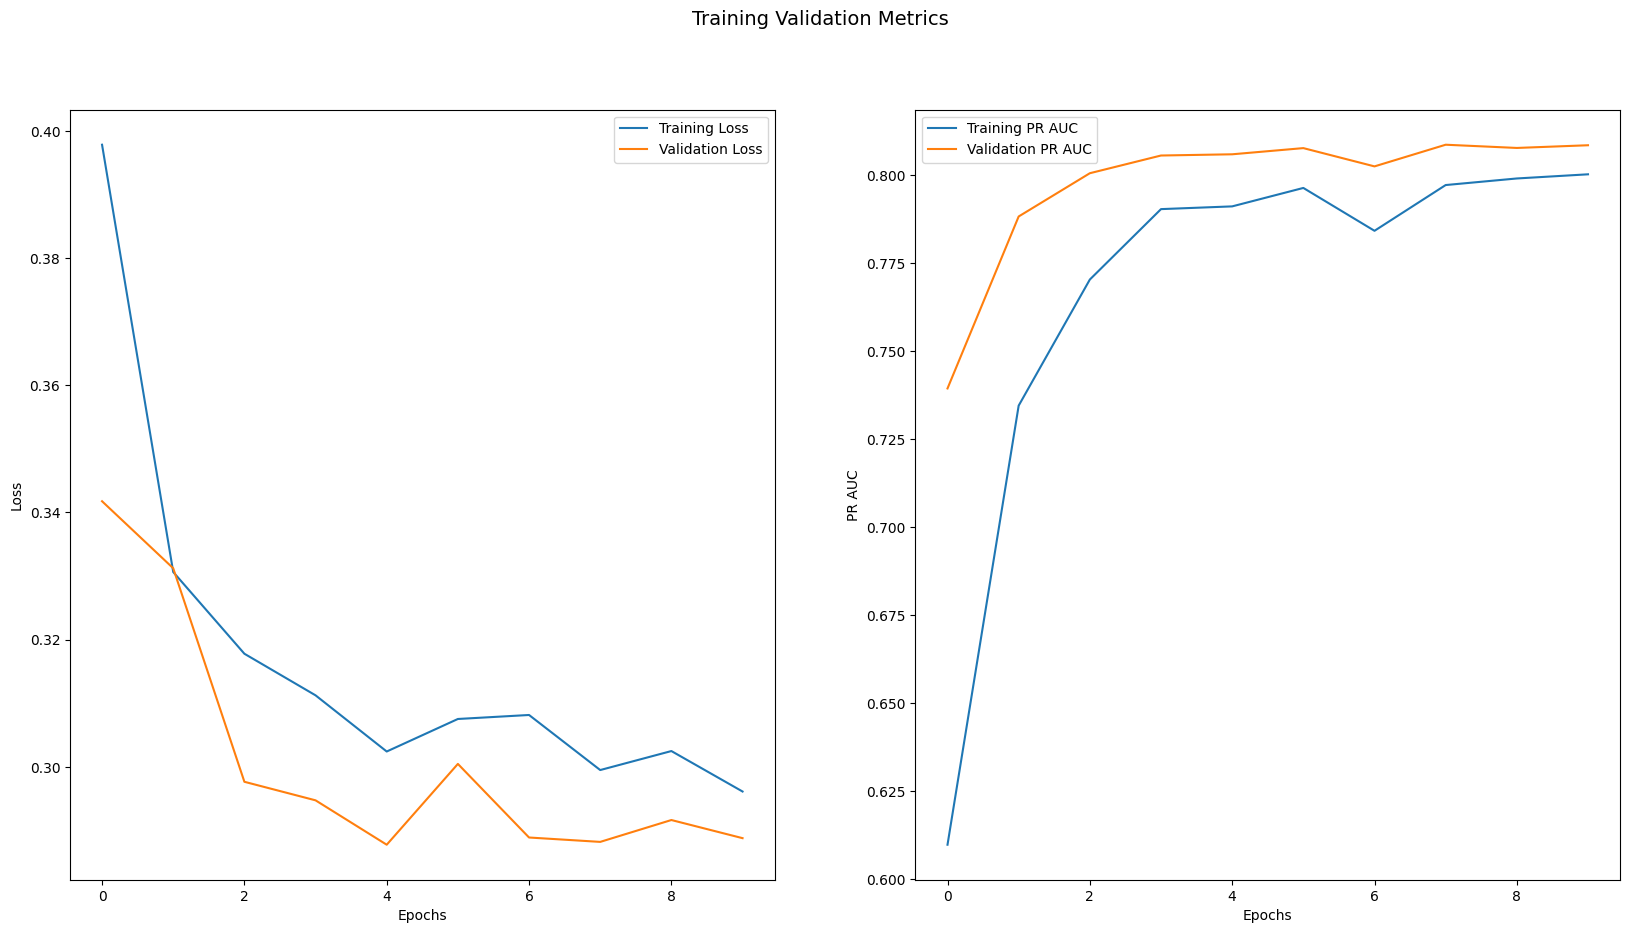

In [22]:
hist_plot = plot_training_hist(hist.history, EXPLANATIONS)

In [23]:
preds = model.predict(test_dataset)
print("Test ROC AUC:", np.round(roc_auc_score(test_data[LABEL], preds['output'].ravel()), 4))
print("Test PR AUC:", np.round(average_precision_score(test_data[LABEL], preds['output'].ravel()), 4))
print("Test Accuracy:", np.round(accuracy_score(test_data[LABEL], preds['output'].ravel()>0.5), 4))

# Reported accuracy - 0.858

 1/17 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step

2024-03-30 10:19:30.653851: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step
Test ROC AUC: 0.9119
Test PR AUC: 0.7865
Test Accuracy: 0.8606


## Explainability

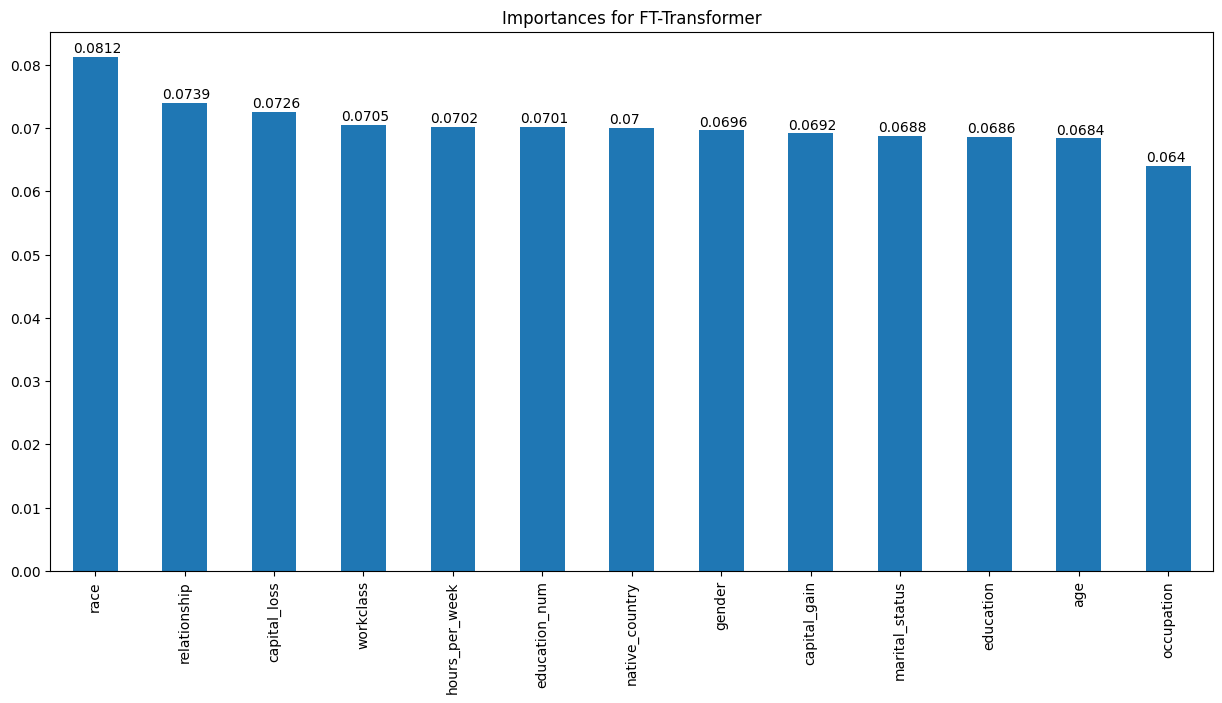

In [24]:
if 'importances' in preds.keys():
    importances = preds['importances']
    importances_df = pd.DataFrame(importances[:, :-1], columns = FEATURES)
    importances_fig, total_importances = plot_importances(
        importances_df, 
        title="Importances for FT-Transformer"
    )

## Quantile PLE Transformer

In [24]:
model = ft_transformer(
    out_dim=1,
    out_activation='sigmoid',
    numerical_features=NUMERIC_FEATURES,
    categorical_features=CATEGORICAL_FEATURES,
    feature_unique_counts=feature_unique_counts,
    seq_length=seq_length,
    numerical_embedding_type='ple',
    bins_dict=q_bins_dict,
    explainable=EXPLANATIONS
)

optimizer = keras.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

loss_dict = {"output": keras.losses.BinaryCrossentropy()}
metrics_dict = {"output": [keras.metrics.AUC(name="PR AUC", curve='PR')]}
if EXPLANATIONS:
    loss_dict.update({"importances": None})
    metrics_dict.update({"importances": None})

model.compile(
    optimizer=optimizer,
    loss=loss_dict,
    metrics=metrics_dict,
)

early = keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=20, restore_best_weights=True)
callback_list = [early]

In [25]:
hist = model.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/10
24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - PR AUC: 0.4857 - loss: 0.4622

2024-03-30 10:14:32.221750: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - PR AUC: 0.4985 - loss: 0.4569

2024-03-30 10:14:38.610914: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 333ms/step - PR AUC: 0.5022 - loss: 0.4553 - val_PR AUC: 0.6694 - val_loss: 0.3751
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - PR AUC: 0.6900 - loss: 0.3596 - val_PR AUC: 0.6593 - val_loss: 0.3716
Epoch 3/10
 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - PR AUC: 0.7282 - loss: 0.3595

2024-03-30 10:14:41.214983: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-30 10:14:41.255018: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - PR AUC: 0.6895 - loss: 0.3539 - val_PR AUC: 0.7115 - val_loss: 0.3398
Epoch 4/10


2024-03-30 10:14:41.634587: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-30 10:14:41.687058: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - PR AUC: 0.7312 - loss: 0.3313 - val_PR AUC: 0.7558 - val_loss: 0.3319
Epoch 5/10


2024-03-30 10:14:42.069229: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-30 10:14:42.111424: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - PR AUC: 0.7440 - loss: 0.3251 - val_PR AUC: 0.7645 - val_loss: 0.3158
Epoch 6/10


2024-03-30 10:14:42.492353: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-30 10:14:42.539509: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - PR AUC: 0.7718 - loss: 0.3095 - val_PR AUC: 0.7601 - val_loss: 0.3263
Epoch 7/10
 7/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - PR AUC: 0.7730 - loss: 0.3192 

2024-03-30 10:14:42.909634: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-30 10:14:42.952825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - PR AUC: 0.7760 - loss: 0.3148 - val_PR AUC: 0.7861 - val_loss: 0.3078
Epoch 8/10


2024-03-30 10:14:43.233433: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-30 10:14:43.276392: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - PR AUC: 0.7910 - loss: 0.3038 - val_PR AUC: 0.7899 - val_loss: 0.3067
Epoch 9/10


2024-03-30 10:14:43.657778: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-30 10:14:43.703544: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - PR AUC: 0.7966 - loss: 0.2989 - val_PR AUC: 0.7953 - val_loss: 0.3009
Epoch 10/10


2024-03-30 10:14:44.074859: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-30 10:14:44.115071: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - PR AUC: 0.8058 - loss: 0.2956 - val_PR AUC: 0.7953 - val_loss: 0.3028


2024-03-30 10:14:44.490834: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-30 10:14:44.534731: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


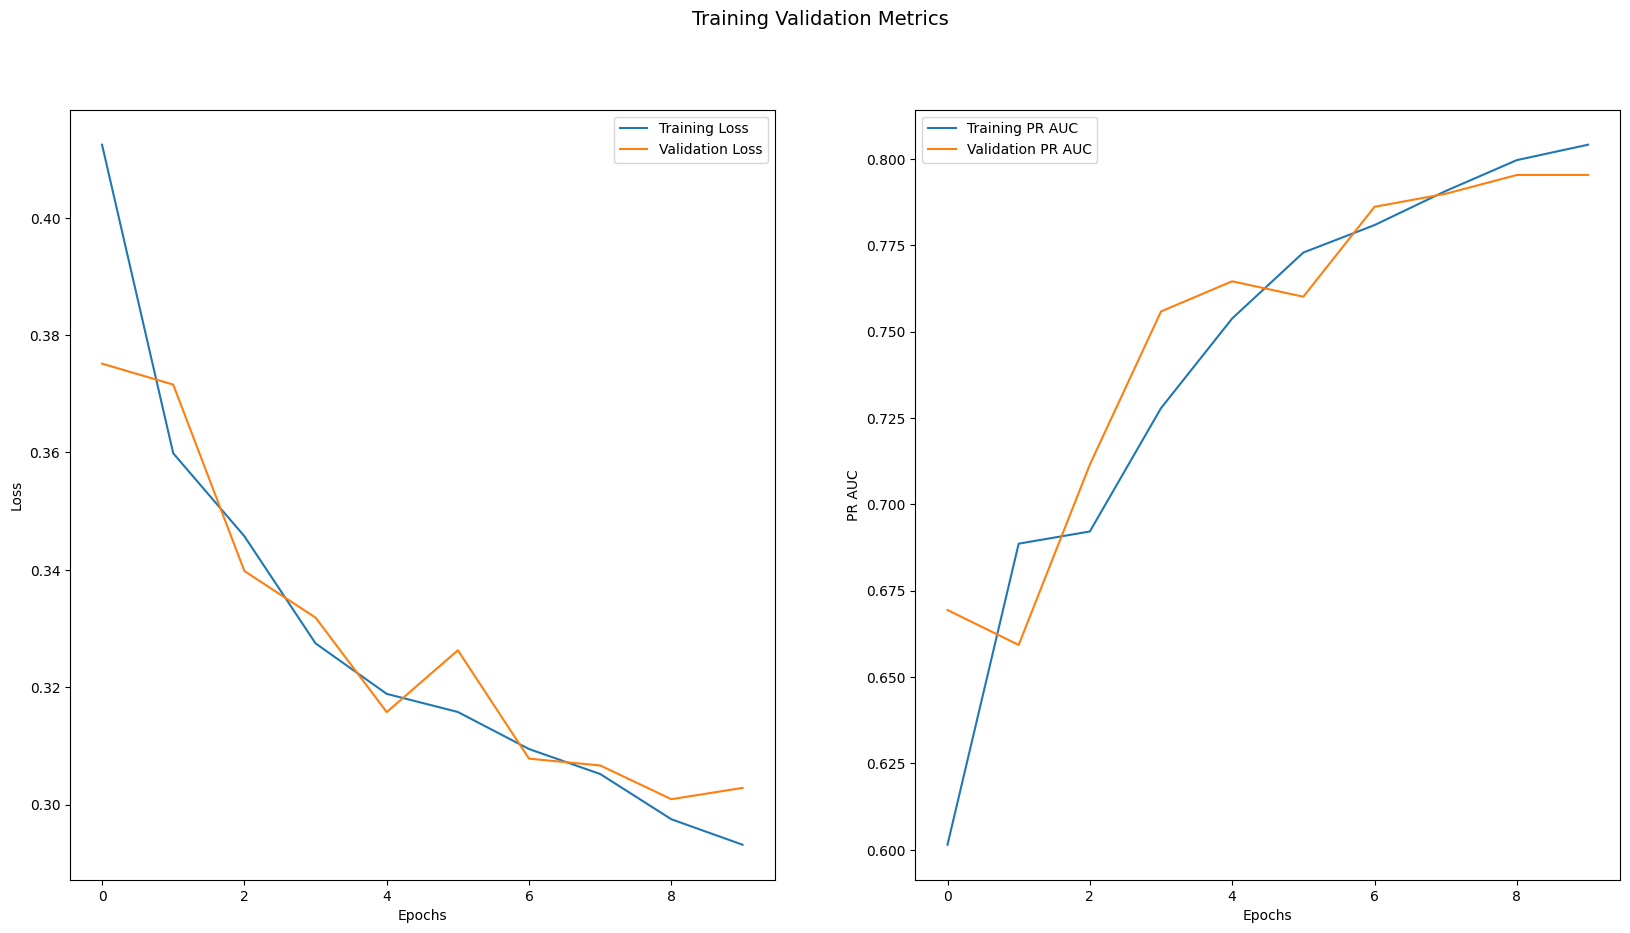

In [26]:
hist_plot = plot_training_hist(hist.history, EXPLANATIONS)

In [27]:
preds = model.predict(test_dataset)
print("Test ROC AUC:", np.round(roc_auc_score(test_data[LABEL], preds['output'].ravel()), 4))
print("Test PR AUC:", np.round(average_precision_score(test_data[LABEL], preds['output'].ravel()), 4))
print("Test Accuracy:", np.round(accuracy_score(test_data[LABEL], preds['output'].ravel()>0.5), 4))

# Reported accuracy - 0.858

 1/17 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step

2024-03-30 10:15:06.081657: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step
Test ROC AUC: 0.9131
Test PR AUC: 0.7864
Test Accuracy: 0.8566


## Explainability

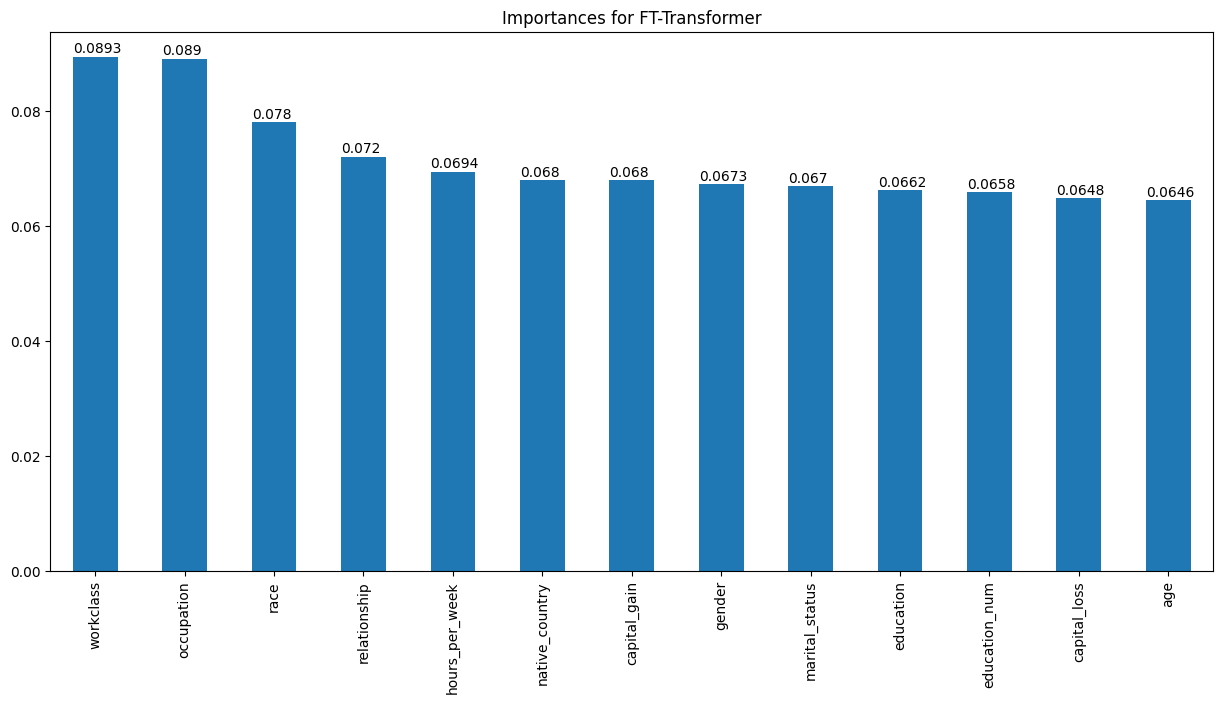

In [29]:
if 'importances' in preds.keys():
    importances = preds['importances']
    importances_df = pd.DataFrame(importances[:, :-1], columns = FEATURES)
    importances_fig, total_importances = plot_importances(
        importances_df, 
        title="Importances for FT-Transformer"
    )